In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/favorita-grocery-sales-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [2]:
!pip install py7zr

In [3]:
import py7zr
from subprocess import check_output

for dirname, _, filenames in os.walk('/kaggle/input/favorita-grocery-sales-forecasting'):
    for filename in filenames:
        archive = py7zr.SevenZipFile(os.path.join(dirname, filename), mode='r')
        archive.extractall(path="/kaggle/working")
        archive.close()

print(check_output(["ls", "../working"]).decode("utf8"))

holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv



## Explore and prepare the data

In [5]:
items = pd.read_csv("../working/items.csv")
holiday_events = pd.read_csv("../working/holidays_events.csv", parse_dates=['date'])
stores = pd.read_csv("../working/stores.csv")
oil = pd.read_csv("../working/oil.csv", parse_dates=['date'])
transactions = pd.read_csv("../working/transactions.csv", parse_dates=['date'])
train = pd.read_csv('../working/train.csv', parse_dates = ['date'])


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.



In [6]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [7]:
train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True
125497039,125497039,2017-08-15,54,2116416,2.0,False


In [8]:
print("Nulls in Oil columns: {0} => {1}".format(oil.columns.values,oil.isnull().any().values))
print("="*70)
print("Nulls in holiday_events columns: {0} => {1}".format(holiday_events.columns.values,holiday_events.isnull().any().values))
print("="*70)
print("Nulls in stores columns: {0} => {1}".format(stores.columns.values,stores.isnull().any().values))
print("="*70)
print("Nulls in transactions columns: {0} => {1}".format(transactions.columns.values,transactions.isnull().any().values))
print("="*70)
print("Nulls in train columns: {0} => {1}".format(train.columns.values,train.isnull().any().values))


Nulls in Oil columns: ['date' 'dcoilwtico'] => [False  True]
Nulls in holiday_events columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] => [False False False False False False]
Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]
Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]
Nulls in train columns: ['id' 'date' 'store_nbr' 'item_nbr' 'unit_sales' 'onpromotion'] => [False False False False False  True]


# Preprocessing

In [9]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()


In [10]:
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='bfill')

In [11]:
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [12]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    21657651
dtype: int64

In [13]:
train['onpromotion'] = train['onpromotion'].fillna('False')

In [14]:
train.isnull().sum()

id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

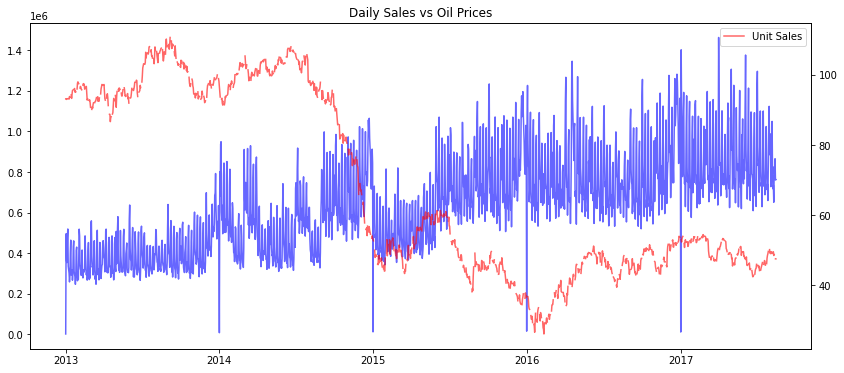

In [15]:
sales_oil = train.groupby("date")["unit_sales"].sum().reset_index()  # Aggregate daily sales
sales_oil = sales_oil.merge(oil, on="date", how="left") 

plt.figure(figsize=(14, 6))

# Plot Sales
plt.plot(sales_oil["date"], sales_oil["unit_sales"], label="Total Unit Sales", color="blue", alpha=0.6)

# Plot Oil Prices on a second y-axis
plt.twinx()
plt.plot(sales_oil["date"], sales_oil["dcoilwtico"], label="Oil Prices", color="red", alpha=0.6)

plt.title("Daily Sales vs Oil Prices")
plt.xlabel("Date")
plt.legend(["Unit Sales", "Oil Prices"])
plt.show()

In [16]:
correlation = sales_oil["unit_sales"].corr(sales_oil["dcoilwtico"])
print(f"Correlation between oil price and sales: {correlation:.4f}")


Correlation between oil price and sales: -0.6902


In [17]:
# Create lag features for oil prices
sales_oil["oil_lag_7"] = sales_oil["dcoilwtico"].shift(7)  # Lag by 7 days
sales_oil["oil_lag_3"] = sales_oil["dcoilwtico"].shift(3)  # Lag by 3 days

# Compute correlation with lagged values
correlation_lag_7 = sales_oil["unit_sales"].corr(sales_oil["oil_lag_7"])
correlation_lag_3 = sales_oil["unit_sales"].corr(sales_oil["oil_lag_3"])

print(f"Correlation with 7-day lag: {correlation_lag_7:.4f}")
print(f"Correlation with 3-day lag: {correlation_lag_3:.4f}")


Correlation with 7-day lag: -0.6861
Correlation with 3-day lag: -0.6090


    store_nbr    unit_sales
43         44  6.208754e+07
44         45  5.449801e+07
46         47  5.094831e+07
2           3  5.048190e+07
48         49  4.342009e+07


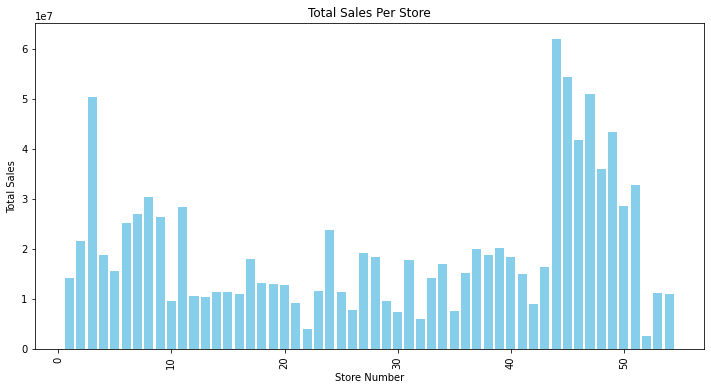

In [18]:
store_sales = train.groupby("store_nbr")["unit_sales"].sum().reset_index()

# Sort stores by sales
store_sales = store_sales.sort_values(by="unit_sales", ascending=False)

print(store_sales.head())

plt.figure(figsize=(12, 6))
plt.bar(store_sales["store_nbr"], store_sales["unit_sales"], color="skyblue")
plt.title("Total Sales Per Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)  # Rotate labels for better visibility
plt.show()

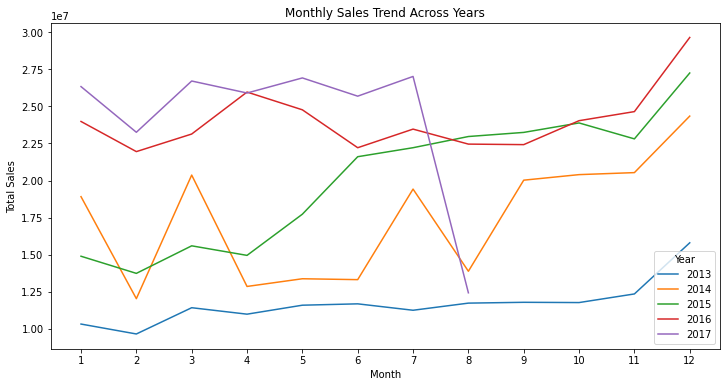

In [19]:
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month

monthly_sales_by_year = train.groupby(["year", "month"])["unit_sales"].sum().reset_index()

import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales_by_year, x="month", y="unit_sales", hue="year", palette="tab10")
plt.title("Monthly Sales Trend Across Years")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(range(1, 13))
plt.legend(title="Year")
plt.show()


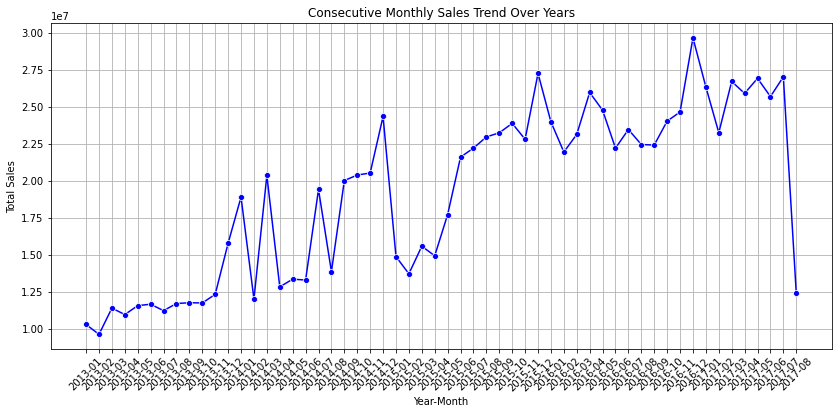

In [20]:
# Create a sequential month-year column for better visualization
train["year_month"] = train["date"].dt.to_period("M")  # Format: YYYY-MM

# Aggregate sales by year-month
monthly_sales = train.groupby("year_month")["unit_sales"].sum().reset_index()

# Convert year_month to string for plotting
monthly_sales["year_month"] = monthly_sales["year_month"].astype(str)

# Plot the sales trend across months and years
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales, x="year_month", y="unit_sales", marker="o", linestyle="-", color="b")
plt.title("Consecutive Monthly Sales Trend Over Years")
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.grid(True)
plt.show()

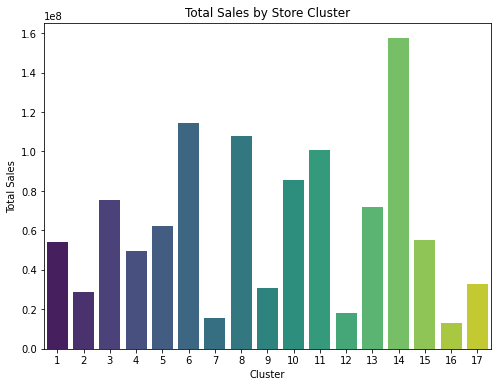

In [21]:
train_with_clusters = pd.merge(train, stores[['store_nbr', 'cluster']], on='store_nbr', how='left')
total_sales_by_cluster = train_with_clusters.groupby('cluster')['unit_sales'].sum().reset_index()
# Plot total sales by cluster
plt.figure(figsize=(8, 6))
sns.barplot(x='cluster', y='unit_sales', data=total_sales_by_cluster, palette='viridis')
plt.title('Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

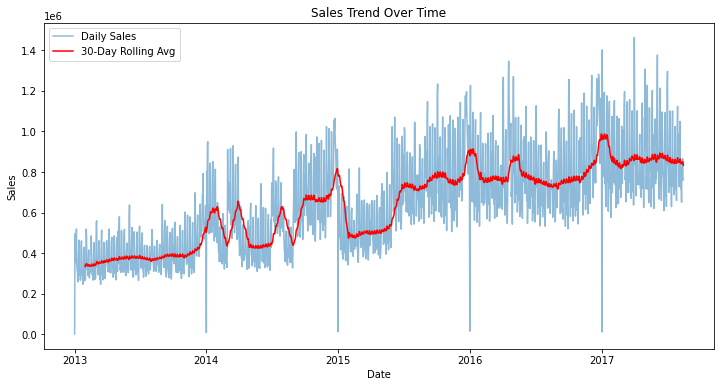

In [22]:
daily_sales = train.groupby('date')['unit_sales'].sum().reset_index()
daily_sales['rolling_avg'] = daily_sales['unit_sales'].rolling(window=30).mean()

# Plot the trend
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['unit_sales'], label='Daily Sales', alpha=0.5)
plt.plot(daily_sales['date'], daily_sales['rolling_avg'], label='30-Day Rolling Avg', color='red')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


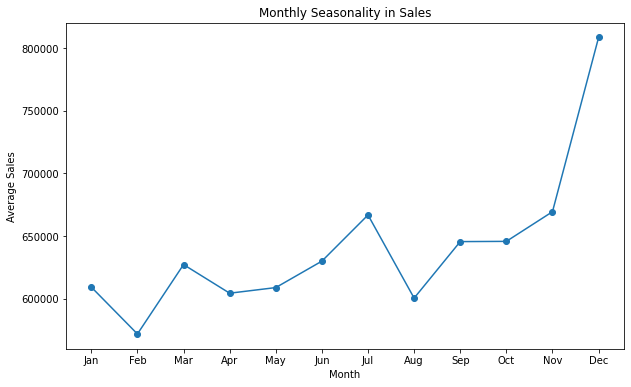

In [23]:
daily_sales['month'] = daily_sales['date'].dt.month

# Aggregate sales by month
monthly_sales = daily_sales.groupby('month')['unit_sales'].mean().reset_index()

# Plot monthly seasonality
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['month'], monthly_sales['unit_sales'], marker='o')
plt.title('Monthly Seasonality in Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

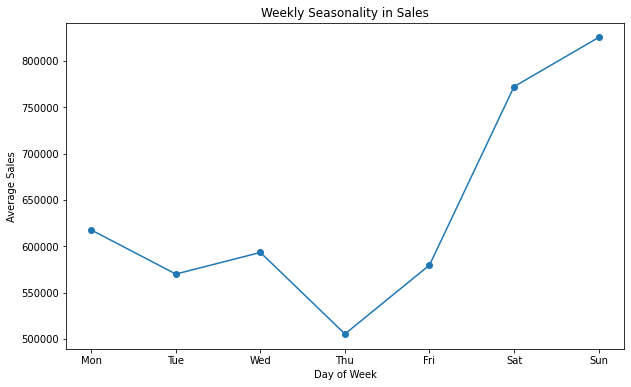

In [24]:
# Extract day of the week from the date (Monday=0, Sunday=6)
daily_sales['day_of_week'] = daily_sales['date'].dt.dayofweek

# Aggregate sales by day of the week
weekly_sales = daily_sales.groupby('day_of_week')['unit_sales'].mean().reset_index()

# Plot weekly seasonality
plt.figure(figsize=(10, 6))
plt.plot(weekly_sales['day_of_week'], weekly_sales['unit_sales'], marker='o')
plt.title('Weekly Seasonality in Sales')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

<Figure size 864x576 with 0 Axes>

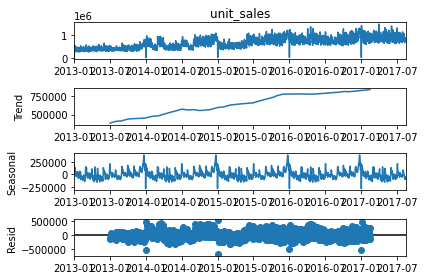

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(daily_sales.set_index('date')['unit_sales'], model='additive', period=365)

# Plot the decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

# Feature Engineering

Time related Features

In [26]:
# Extract time-based features from the 'train' table
train['day_of_week'] = train['date'].dt.dayofweek  # Monday=0, Sunday=6
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['week_of_year'] = train['date'].dt.isocalendar().week

# Create a weekend flag
train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)

Lag Features

In [27]:
train['sales_lag_7'] = train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)

oil['oil_price_lag_7'] = oil['dcoilwtico'].shift(7)

transactions['transactions_lag_7'] = transactions['transactions'].shift(7)

In [28]:
train['sales_rolling_avg_7'] = train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

oil['oil_price_rolling_avg_7'] = oil['dcoilwtico'].rolling(window=7).mean()

transactions['transactions_rolling_avg_7'] = transactions['transactions'].rolling(window=7).mean()

In [29]:
holiday_events['is_holiday'] = holiday_events['type'].apply(lambda x: 1 if x in ['Holiday', 'Event'] else 0)

train = pd.merge(train, holiday_events[['date', 'is_holiday']], on='date', how='left')

In [30]:
del holiday_events

In [31]:
train['is_holiday'] = train['is_holiday'].fillna(0)

In [32]:
train = pd.merge(train, stores[['store_nbr', 'state', 'cluster']], on='store_nbr', how='left')

train = pd.merge(train, items[['item_nbr', 'family', 'perishable']], on='item_nbr', how='left')

In [33]:
del stores

In [34]:
del items


In [35]:
import gc

gc.collect()


188

In [36]:
train = pd.merge(train, oil[['date', 'dcoilwtico','oil_price_lag_7']], on='date', how='left')
# train = pd.merge(train, transactions[['date','transactions']], on='date', how='left')

In [37]:
del oil

In [38]:
del transactions

In [39]:
gc.collect()

92

In [40]:
train = train.iloc[7:].reset_index(drop=True)


In [41]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,year_month,day_of_week,...,is_weekend,sales_lag_7,sales_rolling_avg_7,is_holiday,state,cluster,family,perishable,dcoilwtico,oil_price_lag_7
0,7,2013-01-01,25,108952,1.0,False,2013,1,2013-01,1,...,0,NaN,NaN,1.0,Santa Elena,1,CLEANING,0,93.14,NaN
1,8,2013-01-01,25,111397,13.0,False,2013,1,2013-01,1,...,0,NaN,NaN,1.0,Santa Elena,1,GROCERY I,0,93.14,NaN
2,9,2013-01-01,25,114790,3.0,False,2013,1,2013-01,1,...,0,NaN,NaN,1.0,Santa Elena,1,GROCERY I,0,93.14,NaN
3,10,2013-01-01,25,114800,1.0,False,2013,1,2013-01,1,...,0,NaN,NaN,1.0,Santa Elena,1,PERSONAL CARE,0,93.14,NaN
4,11,2013-01-01,25,115267,1.0,False,2013,1,2013-01,1,...,0,NaN,NaN,1.0,Santa Elena,1,CLEANING,0,93.14,NaN


In [42]:
train.isnull().sum()

id                            0
date                          0
store_nbr                     0
item_nbr                      0
unit_sales                    0
onpromotion                   0
year                          0
month                         0
year_month                    0
day_of_week                   0
week_of_year                  0
is_weekend                    0
sales_lag_7             1223426
sales_rolling_avg_7     1050109
is_holiday                    0
state                         0
cluster                       0
family                        0
perishable                    0
dcoilwtico             38926163
oil_price_lag_7        39166025
dtype: int64

In [43]:
# Drop unnecessary columns
train = train.drop(columns=['id', 'year_month'])

In [47]:
# Forward fill missing values in oil-related columns
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill')
train['oil_price_lag_7'] = train['oil_price_lag_7'].fillna(method='bfill')

# Fill missing values with the mean of the column
train['sales_lag_7'] = train['sales_lag_7'].fillna(train['sales_lag_7'].mean())
train['sales_rolling_avg_7'] = train['sales_rolling_avg_7'].fillna(train['sales_rolling_avg_7'].mean())

In [48]:
train.isnull().sum()

date                   0
store_nbr              0
item_nbr               0
unit_sales             0
onpromotion            0
year                   0
month                  0
day_of_week            0
week_of_year           0
is_weekend             0
sales_lag_7            0
sales_rolling_avg_7    0
is_holiday             0
state                  0
cluster                0
family                 0
perishable             0
dcoilwtico             0
oil_price_lag_7        0
dtype: int64

In [49]:
from sklearn.preprocessing import LabelEncoder

cat_features  = ['store_nbr', 'item_nbr', 'state', 'cluster', 'family', 'onpromotion', 'weekofyear']
label_encoders = {}

for col in cat_features:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])

In [50]:
from sklearn.preprocessing import StandardScaler

num_features = ["unit_sales", "dcoilwtico", "sales_rolling_avg_7", "oil_price_lag_7"]
scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])


In [54]:
train['onpromotion'] = train['onpromotion'].astype(bool)


In [55]:
train['week_of_year'] = train['week_of_year'].astype(int)


## Training Data

In [56]:
# Define features (all columns except 'unit_sales' and 'date')
features = [col for col in train.columns if col not in ['unit_sales', 'date']]
X = train[features]
y = train['unit_sales']

# Display the features and target variable
print("Features:")
print(X.head())

print("\nTarget Variable:")
print(y.head())

Features:
   store_nbr  item_nbr  onpromotion  year  month  day_of_week  week_of_year  \
0         24        23         True  2013      1            1             1   
1         24        25         True  2013      1            1             1   
2         24        28         True  2013      1            1             1   
3         24        30         True  2013      1            1             1   
4         24        31         True  2013      1            1             1   

   is_weekend  sales_lag_7  sales_rolling_avg_7  is_holiday  state  cluster  \
0           0     8.579298         8.321567e-12         1.0     13        0   
1           0     8.579298         8.321567e-12         1.0     13        0   
2           0     8.579298         8.321567e-12         1.0     13        0   
3           0     8.579298         8.321567e-12         1.0     13        0   
4           0     8.579298         8.321567e-12         1.0     13        0   

   family  perishable  dcoilwtico  oil_p

In [57]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shapes of the datasets
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")

Training data shape: (102376200, 17), (102376200,)
Validation data shape: (25594050, 17), (25594050,)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

In [ ]:
# Plot feature importance
xgb.plot_importance(model)
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize the data (LSTMs work better with normalized data)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Reshape the data for LSTM
def create_sequences(data, timesteps=7):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(data)):
        X_seq.append(data[i-timesteps:i])
        y_seq.append(data[i])
    return np.array(X_seq), np.array(y_seq)

# Define the number of timesteps (e.g., 7 days)
timesteps = 7
X_seq, y_seq = create_sequences(X_scaled, timesteps)

# Split the data into training and validation sets
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Check the shapes of the datasets
print(f"LSTM Training data shape: {X_train_lstm.shape}, {y_train_lstm.shape}")
print(f"LSTM Validation data shape: {X_val_lstm.shape}, {y_val_lstm.shape}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Further Analysis

In [ ]:
sale_day_item_level= pd.read_csv("../input/memory-optimization-data-manipulation/sale_day_item_level.csv")
sale_day_store_level= pd.read_csv("../input/memory-optimization-data-manipulation/sale_day_store_level.csv")
sale_store_item_level= pd.read_csv("../input/memory-optimization-data-manipulation/sale_store_item_level.csv")

In [ ]:
#Creating store level metrics
sale_store_level=sale_day_store_level.groupby(['store_nbr'],as_index=False)['store_sales','item_variety'].agg(['sum'])

# Here the group by gives a multiindex , removing that
sale_store_level.columns = sale_store_level.columns.droplevel(1)
sale_store_level=sale_store_level.reset_index()
sale_store_level.head()

In [ ]:
#Creating item level metrics
sale_item_level=sale_day_item_level.groupby(['item_nbr'],as_index=False)['item_sales'].agg(['sum'])

sale_item_level=sale_item_level.reset_index()
sale_item_level.head()

In [ ]:
# Sorting by sales
temp=sale_store_level.sort_values('store_sales',ascending=False).reset_index(drop=True)
temp=temp.set_index('store_nbr').head(10)

plt.figure(figsize=(12,8))
sns.barplot(temp.index,temp.store_sales, alpha=0.6, color='blue')
plt.ylabel('Overall Sales', fontsize=12)
plt.xlabel('Store Number', fontsize=12)
plt.title('Top Stores by Overall sale', fontsize=15)
# plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# Sorting by sales
temp1=sale_item_level.sort_values('sum',ascending=False).reset_index(drop=True)
temp1=temp1.set_index('item_nbr').head(10)
plt.figure(figsize=(12,8))
x=temp1.index.values
y=temp1['sum'].values
sns.barplot(x,y, alpha=0.6, color='purple')
plt.ylabel('Overall Sales', fontsize=12)
plt.xlabel('Store Number', fontsize=12)
plt.title('Top Items by Overall sale', fontsize=15)
plt.show()

In [ ]:
#YOY sales
temp=sale_day_store_level.groupby('Year')['store_sales'].sum()
plt.figure(figsize=(13,4))
sns.pointplot(temp.index,temp.values, alpha=0.8)
plt.ylabel('Overall Sales', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Sale Year Over Year', fontsize=15)
plt.xticks(rotation='vertical')

plt.show()

In [ ]:
# month over month sales
temp=sale_day_store_level.groupby(['Year','Month']).aggregate({'store_sales':np.sum,'Year':np.min,'Month':np.min})
temp=temp.reset_index(drop=True)
sns.set(style="whitegrid", color_codes=True)
# temp
plt.figure(figsize=(15,8))
plt.plot(range(1,13),temp.iloc[0:12,0],label="2013")
plt.plot(range(1,13),temp.iloc[12:24,0],label="2014")
plt.plot(range(1,13),temp.iloc[24:36,0],label="2015")
plt.plot(range(1,13),temp.iloc[36:48,0],label="2015")
plt.ylabel('Overall Sales', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Monthly sales variation', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(['2013', '2014', '2015', '2016'], loc='upper left')
plt.show()

### Store Distrubution

In [ ]:
#Count of stores in different types and clusters
plt.figure(figsize=(15,12))
#row col plotnumber - 121
plt.subplot(221)
# Count of stores for each type 
temp = stores['cluster'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[5])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.title('Store distribution across cluster', fontsize=15)

plt.subplot(222)
# Count of stores for each type 
temp = stores['type'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[7])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('Type of store', fontsize=12)
plt.title('Store distribution across store types', fontsize=15)

plt.subplot(223)
# Count of stores for each type 
temp = stores['state'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[8])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('state', fontsize=12)
plt.title('Store distribution across states', fontsize=15)
plt.xticks(rotation='vertical')

plt.subplot(224)
# Count of stores for each type 
temp = stores['city'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[9])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.title('Store distribution across cities', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

### Sale distribution

In [ ]:
sale_store_level=sale_store_level.iloc[:,0:2]
#print(sale_store_level)
merge=pd.merge(sale_store_level,stores,how='left',on='store_nbr')
#temp

#Sale of stores in different types and clusters
plt.figure(figsize=(15,12))
#row col plotnumber - 121
plt.subplot(221)
# Sale of stores for each type 
temp = merge.groupby(['cluster'])['store_sales'].sum()
#plot
sns.barplot(temp.index,temp.values,color=color[5])
plt.ylabel('Sales', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.title('Cumulative sales across store clusters', fontsize=15)

plt.subplot(222)
# sale of stores for each type 
temp = merge.groupby(['type'])['store_sales'].sum()
#plot
sns.barplot(temp.index,temp.values,color=color[7])
plt.ylabel('sales', fontsize=12)
plt.xlabel('Type of store', fontsize=12)
plt.title('Cumulative sales across store types', fontsize=15)

plt.subplot(223)
# sale of stores for each type 
temp = merge.groupby(['state'])['store_sales'].sum()
#plot
sns.barplot(temp.index,temp.values,color=color[8])
plt.ylabel('sales', fontsize=12)
plt.xlabel('state', fontsize=12)
plt.title('Cumulative sales across states', fontsize=15)
plt.xticks(rotation='vertical')

plt.subplot(224)
# sale of stores for city
temp = merge.groupby(['city'])['store_sales'].sum()
#plot
sns.barplot(temp.index,temp.values,color=color[9])
plt.ylabel('sales', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.title('Cumulative sales across cities', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
store_items=pd.merge(sale_store_item_level,items,on='item_nbr')
store_items=pd.merge(store_items,stores,on='store_nbr')
store_items['item_sales']=store_items['item_sales']

#item
# top selling items by store type
top_items_by_type=store_items.groupby(['type','item_nbr'])['item_sales'].sum()
top_items_by_type=top_items_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])

#get top 5
top_items_by_type=top_items_by_type.groupby(['type']).head(5)


#class
# top selling item class by store type
top_class_by_type=store_items.groupby(['type','class'])['item_sales'].sum()
top_class_by_type=top_class_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])

#get top 5
top_class_by_type=top_class_by_type.groupby(['type']).head(5)


#family
# top selling item family by store type
top_family_by_type=store_items.groupby(['type','family'])['item_sales'].sum()
top_family_by_type=top_family_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])

#get top 5
top_family_by_type=top_family_by_type.groupby(['type']).head(5)

In [ ]:
top_family_by_type=store_items.groupby(['type','family'])['item_sales'].sum()
top_family_by_type=top_family_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])
x=top_family_by_type.pivot(index='family',columns='type')
cm = sns.light_palette("orange", as_cmap=True)
x = x.style.background_gradient(cmap=cm)
x

In [ ]:
top_items_by_type=store_items.groupby(['type','item_nbr'])['item_sales'].sum()
top_items_by_type=top_items_by_type.reset_index().sort_values(['type','item_sales'],ascending=[True,False])
top_items_by_type=top_items_by_type.groupby(['item_nbr']).head(20)
#print(top_items_by_type)
x=top_items_by_type.pivot(index='item_nbr',columns='type')
x['total']=x.sum(axis=1)
x=x.sort_values('total',ascending=False)
del(x['total'])
x=x.head(30)
cm = sns.light_palette("green", as_cmap=True)
x = x.style.background_gradient(cmap=cm,axis=1)
x

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipe_processing = Pipeline([
        ('prepare_data', prepare_data()),
        ('split_data', split_data()),
        ('process_data', process_data()),
        ('join_data', join_df())
    ])

# our prepared data
data_df = pipe_processing.fit_transform([train_large, stores, oil, items, transactions, holiday_events])

# split it according to our feature engineering
X = data_df.drop(['unit_sales', 'transactions'], axis=1)
Y = data_df[['unit_sales', 'transactions']]

# Modelling and testing

### Generic function for modelling and testing

In [ ]:
from sklearn.linear_model import LinearRegression,SGDRegressor,ElasticNet,Ridge
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error


def checkModelPerformane(model):
    model.fit(x_train.values, y_train.values)
    
    pred = model.predict(x_test.values)
    
    print("mean_squared_error: ",np.sqrt(mean_squared_error(y_test.values, pred))) 
    print("mean_absolute_error: ", np.sqrt(mean_absolute_error(y_test.values, pred)))

### Linear regression

In [ ]:
print("LinearRegression")
checkModelPerformane(LinearRegression())

### Random forests

In [ ]:
print("Random Forest")
checkModelPerformane(RandomForestRegressor(random_state=42)) 

Random forest model has the lowest error, thus we are going to use it and fine tune it.

# Model fine tuning

### Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor(random_state=42)
 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(x_train.values, y_train.values)

### find out the best parameters for our model

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

# Test model on test set

In [ ]:
!head test.csv

In [ ]:
final_model = grid_search.best_estimator_

# load and process data
test = pd.read_csv("../working/test.csv", parse_dates=['date'])

pipe_processing2 = Pipeline([
        ('split_data', split_data()),
        ('process_data', process_data()),
        ('join_data', join_df())
    ])

test_df = pipe_processing2.fit_transform(test)



In [ ]:
test_df


In [ ]:
# final_predictions = final_model.predict(test_x)